


<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<h5> Problem statement : </h5> <p> Classify the given genetic variations based on evidence from text-based clinical literature. </p>

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

Data file's information:<br>
training_variants (ID , Gene, Variations, Class) <br>
training_text (ID, Text) <br>

<h3>2.1.2. Example Data Point</h3>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>


There are nine different classes a genetic mutation can be classified into => Multi class classification problem

<h3>2.2.2. Performance Metric</h3>

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability <br>
* Class probabilities are needed. <br>
* Penalize the errors in class probabilites => Metric is Log-loss. <br>
* No Latency constraints. <br>

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import math
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import hstack
from collections import Counter, defaultdict
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import normalized_mutual_info_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [3]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Jyoti
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 179.7581353 seconds


In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='right')
print(result.count())
result.head()

ID           3321
Gene         3321
Variation    3321
Class        3321
TEXT         3316
dtype: int64


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [10]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [11]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [12]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

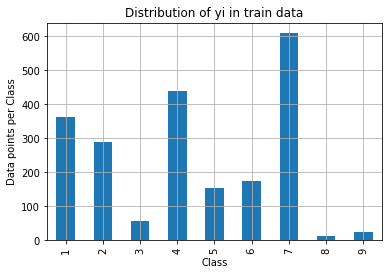

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


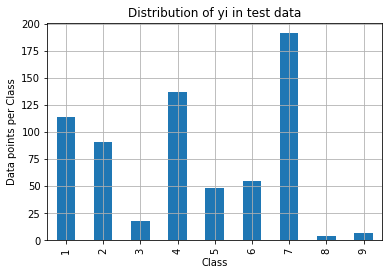

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


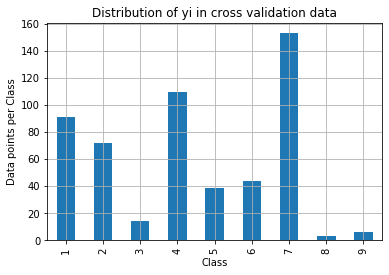

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [13]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h2>3.2 Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [14]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.530690316204592
Log loss on Test Data using Random Model 2.491978665527975
-------------------- Confusion matrix --------------------


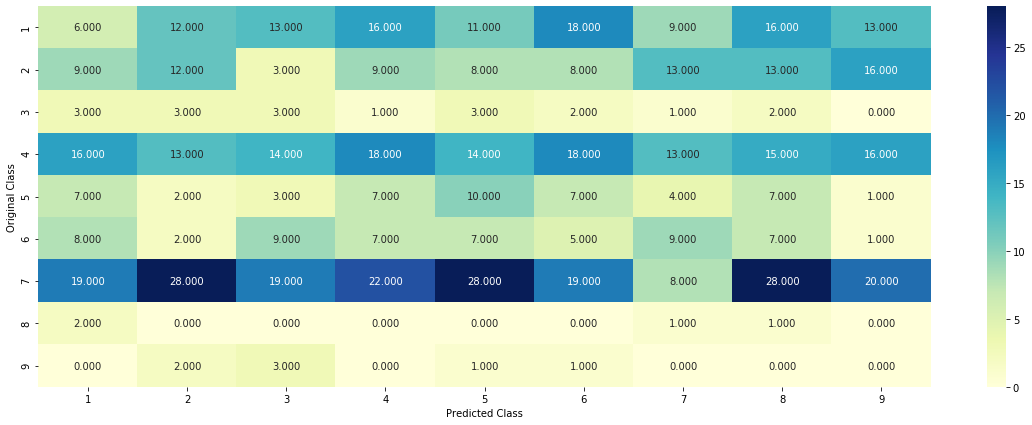

-------------------- Recall matrix (Row sum=1) --------------------


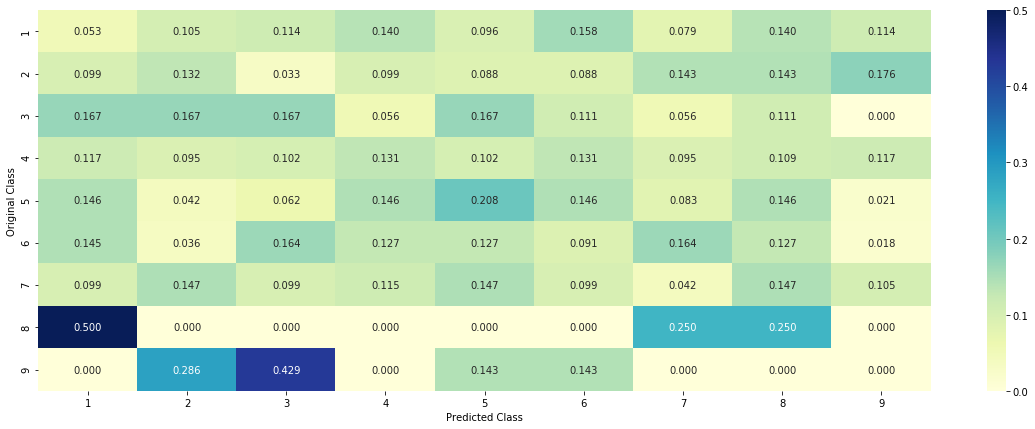

-------------------- Precision matrix (Columm Sum=1) --------------------


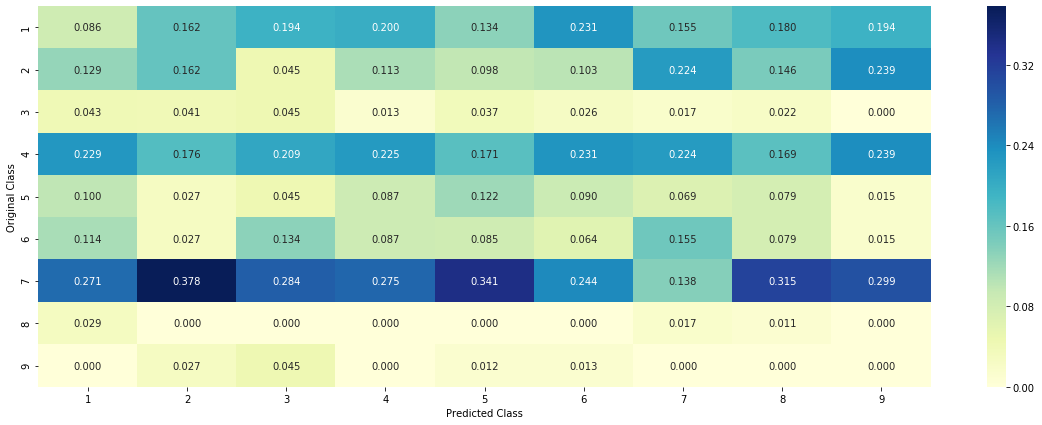

In [15]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h2>3.3 Univariate Analysis</h2>

In [16]:
# code for response coding with Laplace smoothing.

# get_gv_fea_dict: Get Gene variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature 
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3>3.2.1 Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [17]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 240
BRCA1     167
TP53       99
BRCA2      82
EGFR       82
PTEN       77
KIT        69
BRAF       54
ERBB2      40
ALK        39
PDGFRA     39
Name: Gene, dtype: int64


In [18]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 240 different categories of genes in the train data, and they are distibuted as follows


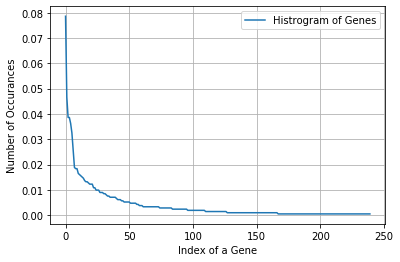

In [19]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

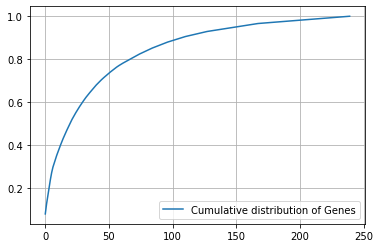

In [20]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [22]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [23]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [24]:
train_df['Gene'].head()

1323     MLH1
55      PTPRT
2897    BRCA2
2151     PTEN
2226     PTEN
Name: Gene, dtype: object

In [25]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ikzf1'

In [26]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 239)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2079173042583475
For values of alpha =  0.0001 The log loss is: 1.190813511279592
For values of alpha =  0.001 The log loss is: 1.244488927917157
For values of alpha =  0.01 The log loss is: 1.3583516875445554
For values of alpha =  0.1 The log loss is: 1.438107586488645
For values of alpha =  1 The log loss is: 1.469635208042869


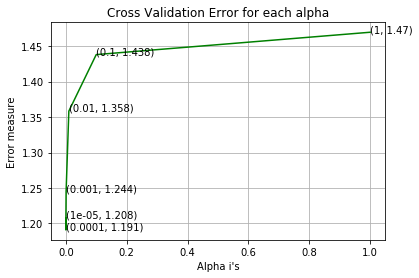

For values of best alpha =  0.0001 The train log loss is: 1.005963760357871
For values of best alpha =  0.0001 The cross validation log loss is: 1.190813511279592
For values of best alpha =  0.0001 The test log loss is: 1.1683156046969743


In [27]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [28]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  240  genes in train dataset?
Ans
1. In test data 650 out of 665 : 97.74436090225564
2. In cross validation data 514 out of  532 : 96.61654135338345


<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [29]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1915
Truncating_Mutations    59
Deletion                53
Amplification           52
Fusions                 22
Overexpression           4
G12V                     3
T58I                     3
E17K                     3
E542K                    2
EWSR1-ETV1_Fusion        2
Name: Variation, dtype: int64


In [30]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1915 different categories of variations in the train data, and they are distibuted as follows


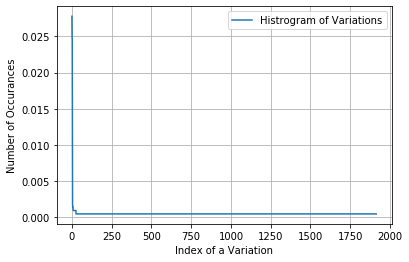

In [31]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02777778 0.0527307  0.07721281 ... 0.99905838 0.99952919 1.        ]


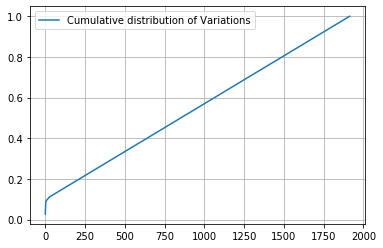

In [32]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [33]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [34]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [35]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [36]:
train_variation_feature_onehotCoding

<2124x1952 sparse matrix of type '<class 'numpy.int64'>'
	with 2233 stored elements in Compressed Sparse Row format>

In [37]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1952)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7132533760615802
For values of alpha =  0.0001 The log loss is: 1.714436489283278
For values of alpha =  0.001 The log loss is: 1.716418392396306
For values of alpha =  0.01 The log loss is: 1.7168187147753977
For values of alpha =  0.1 The log loss is: 1.7238338947181437
For values of alpha =  1 The log loss is: 1.7255781333153795


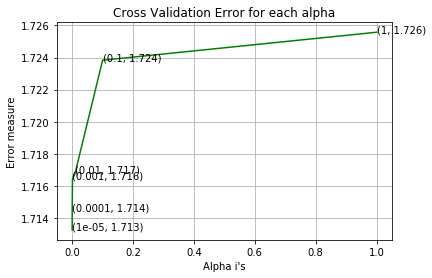

For values of best alpha =  1e-05 The train log loss is: 0.702968344005845
For values of best alpha =  1e-05 The cross validation log loss is: 1.7132533760615802
For values of best alpha =  1e-05 The test log loss is: 1.722792085232713


In [38]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [39]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1915  genes in test and cross validation data sets?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 44 out of  532 : 8.270676691729323


<h3>3.2.3 Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [40]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [41]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [42]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53718


In [43]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [44]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [45]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [46]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [47]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [48]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5778, 4: 3705, 6: 3017, 5: 2579, 7: 2043, 9: 1948, 8: 1909, 10: 1361, 13: 1220, 12: 1208, 11: 1061, 14: 946, 15: 763, 18: 750, 16: 706, 19: 662, 20: 576, 22: 536, 17: 533, 21: 488, 26: 485, 24: 474, 28: 398, 23: 379, 25: 370, 27: 357, 45: 339, 48: 327, 30: 317, 29: 308, 36: 286, 32: 286, 31: 270, 34: 260, 35: 231, 40: 228, 33: 226, 41: 221, 38: 220, 39: 219, 42: 190, 37: 189, 50: 171, 43: 171, 46: 170, 44: 169, 60: 165, 47: 163, 57: 150, 51: 149, 55: 145, 49: 143, 52: 142, 56: 138, 53: 137, 59: 123, 58: 121, 61: 117, 54: 117, 66: 113, 64: 113, 72: 111, 65: 109, 63: 108, 67: 104, 62: 102, 75: 96, 71: 96, 68: 96, 78: 92, 69: 89, 79: 85, 70: 85, 77: 84, 81: 83, 85: 81, 76: 81, 82: 80, 84: 79, 80: 79, 73: 79, 83: 78, 96: 76, 90: 70, 86: 70, 74: 70, 91: 69, 97: 68, 88: 65, 87: 65, 92: 62, 94: 60, 104: 59, 108: 58, 93: 58, 89: 57, 98: 55, 116: 54, 110: 54, 103: 54, 112: 53, 123: 52, 105: 52, 114: 51, 102: 51, 115: 48, 100: 48, 121: 47, 117: 47, 136: 46, 129: 46, 120: 46, 109: 46,

For values of alpha =  1e-05 The log loss is: 1.284405608968231
For values of alpha =  0.0001 The log loss is: 1.1207252699487986
For values of alpha =  0.001 The log loss is: 1.0991942845925133
For values of alpha =  0.01 The log loss is: 1.2251197067303805
For values of alpha =  0.1 The log loss is: 1.421766901718052
For values of alpha =  1 The log loss is: 1.605273354972431


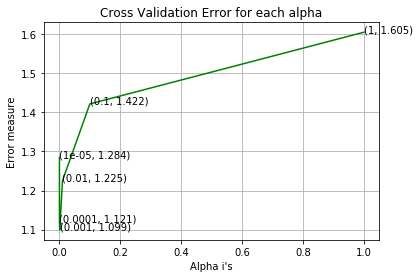

For values of best alpha =  0.001 The train log loss is: 0.6955315539664875
For values of best alpha =  0.001 The cross validation log loss is: 1.0991942845925133
For values of best alpha =  0.001 The test log loss is: 1.1377651250981777


In [49]:
# Train a Logistic regression+Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [50]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

<h1>4. Machine Learning Models</h1>

In [52]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [53]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [54]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [55]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [56]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55909)
(number of data points * number of features) in test data =  (665, 55909)
(number of data points * number of features) in cross validation data = (532, 55909)


In [57]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

<h4>4.1.1.1. Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.2546272214535517
for alpha = 0.0001
Log Loss : 1.261143650218505
for alpha = 0.001
Log Loss : 1.265712325339735
for alpha = 0.1
Log Loss : 1.2766268995356624
for alpha = 1
Log Loss : 1.29182657944274
for alpha = 10
Log Loss : 1.3806714364666044
for alpha = 100
Log Loss : 1.3794687849344065
for alpha = 1000
Log Loss : 1.3101461784946906


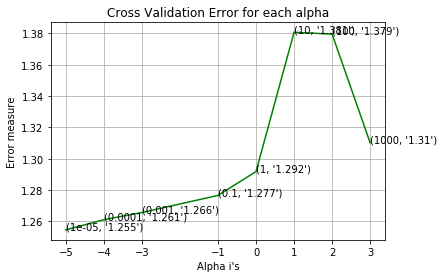

For values of best alpha =  1e-05 The train log loss is: 0.8301766919675662
For values of best alpha =  1e-05 The cross validation log loss is: 1.2546272214535517
For values of best alpha =  1e-05 The test log loss is: 1.2743191694326164


In [58]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.2546272214535517
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


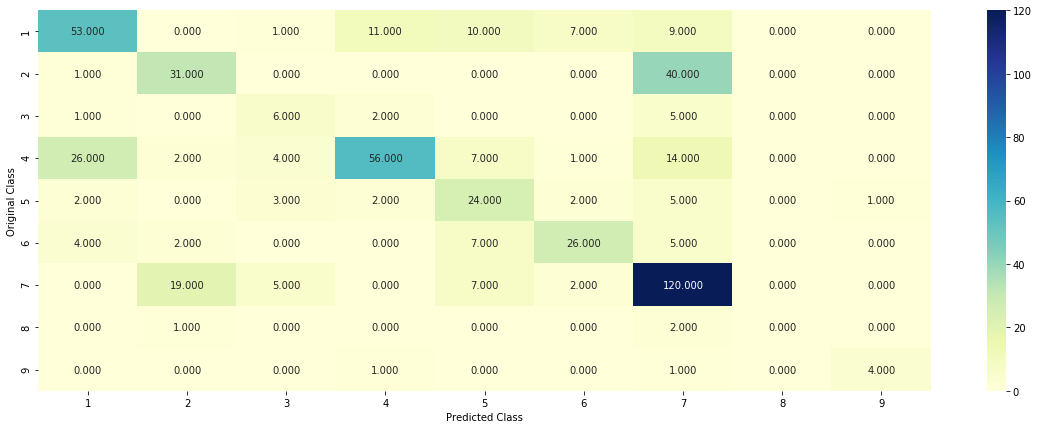

-------------------- Recall matrix (Row sum=1) --------------------


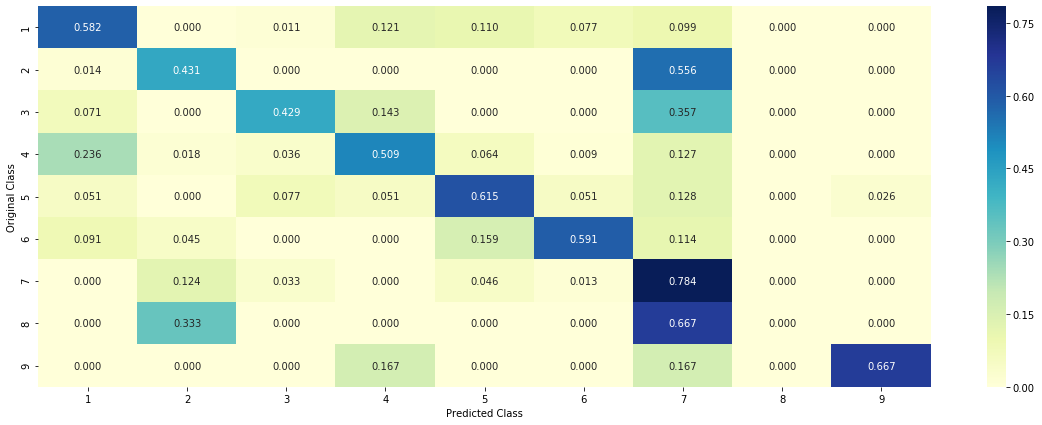

-------------------- Precision matrix (Columm Sum=1) --------------------


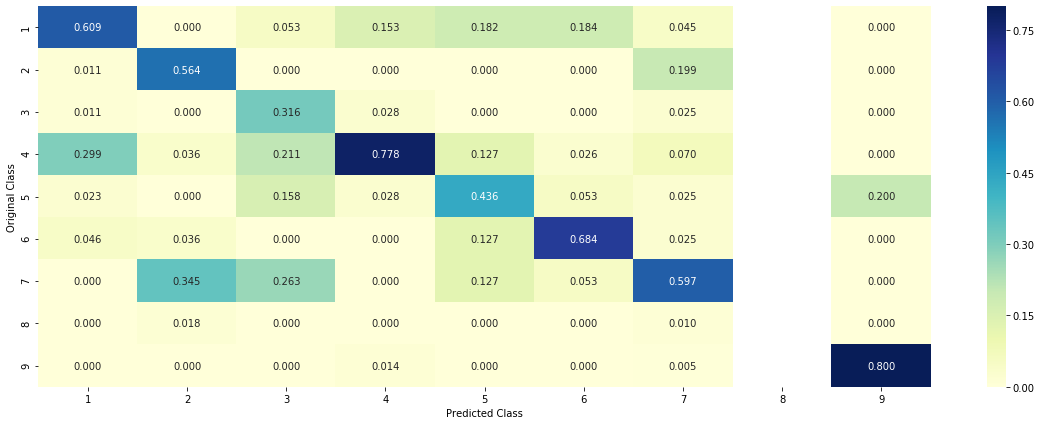

In [59]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>4.1.1.3. Feature Importance, Correctly classified point</h4>

In [60]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1188 0.1077 0.0174 0.1401 0.4402 0.0498 0.1152 0.006  0.0048]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [61]:
test_df['TEXT'].iloc[test_point_index]

'mutations brca1 brca2 account majority hereditary breast ovarian cancers therefore sequence analysis genes routinely conducted patients early onset breast cancer besides mutations clearly abolish protein function known increase cancer risk large number sequence variants uncertain signifi cance vus identifi ed although several functional assays brca1 vuss described thus far possible conduct high throughput analysis context full length protein developed relatively fast easy cdna based functional assay classify brca1 vuss based ability functionally complement brca1 defi cient mouse embryonic stem cells using assay analyzed 74 unclassifi ed brca1 missense mutants predicted pathogenic variants confi ned brca1 ring brct domains significance brca1 vuss frequently found patients hereditary breast ovarian cancer present serious problem clinical geneticists article describes generation validation application reliable high throughput assay functional classifi cation brca1 sequence variants uncer

In [62]:
no_feature

100

In [63]:
test_df['Gene'].iloc[test_point_index]

'BRCA1'

In [64]:
test_df['Variation'].iloc[test_point_index]

'D1739V'

In [65]:
clf.coef_.shape

(9, 55909)

In [66]:
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
indices[0]

array([    0, 33383, 33386, 33387, 33388, 33389, 33390, 33391, 33392,
       33393, 33394, 33396, 33397, 33398, 33399, 33400, 33401, 33403,
       33381, 33380, 33379, 33375, 33349, 33353, 33354, 33355, 33358,
       33359, 33360, 33362, 33404, 33363, 33365, 33368, 33369, 33370,
       33371, 33372, 33373, 33374, 33364, 33405, 33406, 33410, 33449,
       33451, 33452, 33453, 33454, 33456, 33458, 33459, 33448, 33462,
       33464, 33467, 33468, 33469, 33470, 33471, 33472, 33473, 33463,
       33347, 33447, 33445, 33413, 33415, 33423, 33424, 33425, 33428,
       33429, 33431, 33446, 33433, 33436, 33438, 33439, 33440, 33441,
       33442, 33443, 33444, 33435, 33476, 33346, 33344, 33255, 33258,
       33259, 33260, 33262, 33263, 33267, 33269, 33270, 33271, 33274,
       33276], dtype=int64)

In [67]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [68]:
for i in range(10):
  test_point_index = i
  no_feature = 100
  predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
  print("Predicted Class :", predicted_cls[0])
  print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
  print("Actual Class :", test_y[test_point_index])
  indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:]
  print("-"*50)
  get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0873 0.079  0.0129 0.6566 0.0351 0.0365 0.0845 0.0044 0.0036]]
Actual Class : 4
--------------------------------------------------
442 Text feature [improbable] present in test data point [True]
7006 Text feature [extracolonic] present in test data point [True]
7992 Text feature [t17] present in test data point [True]
16717 Text feature [1257] present in test data point [True]
16748 Text feature [1269] present in test data point [True]
16775 Text feature [1389] present in test data point [True]
16823 Text feature [1335] present in test data point [True]
17735 Text feature [804] present in test data point [True]
19046 Text feature [946] present in test data point [True]
22680 Text feature [fgfr1] present in test data point [True]
22696 Text feature [19q] present in test data point [True]
22816 Text feature [erbb3] present in test data point [True]
22851 Text feature [8p12] present in test data point [True]
22861 Text feature [midgut

31492 Text feature [insulin] present in test data point [True]
31914 Text feature [pathway8] present in test data point [True]
31946 Text feature [500kb] present in test data point [True]
32023 Text feature [database33] present in test data point [True]
32061 Text feature [colonic] present in test data point [True]
32076 Text feature [primer3] present in test data point [True]
32102 Text feature [bending] present in test data point [True]
32109 Text feature [triangle] present in test data point [True]
32130 Text feature [257] present in test data point [True]
32157 Text feature [mutl] present in test data point [True]
32193 Text feature [shipped] present in test data point [True]
32236 Text feature [rtk] present in test data point [True]
32279 Text feature [arms] present in test data point [True]
32311 Text feature [mirnas] present in test data point [True]
32486 Text feature [sarcomas] present in test data point [True]
32487 Text feature [fragile] present in test data point [True]
324

37344 Text feature [affymetrix] present in test data point [True]
37364 Text feature [disproportionately] present in test data point [True]
37370 Text feature [connector] present in test data point [True]
37376 Text feature [paraffin] present in test data point [True]
37429 Text feature [webpage] present in test data point [True]
37449 Text feature [correlating] present in test data point [True]
37470 Text feature [variations] present in test data point [True]
37499 Text feature [118] present in test data point [True]
37521 Text feature [microarrays] present in test data point [True]
37588 Text feature [erbb] present in test data point [True]
37623 Text feature [exon] present in test data point [True]
37627 Text feature [table2] present in test data point [True]
37699 Text feature [aggression] present in test data point [True]
37783 Text feature [distinguishable] present in test data point [True]
37785 Text feature [cpg] present in test data point [True]
37800 Text feature [intimate] p

42163 Text feature [displacements] present in test data point [True]
42187 Text feature [spikes] present in test data point [True]
42285 Text feature [rebind] present in test data point [True]
42370 Text feature [basepair] present in test data point [True]
42380 Text feature [016] present in test data point [True]
42383 Text feature [ideal] present in test data point [True]
42388 Text feature [match] present in test data point [True]
42424 Text feature [obtaining] present in test data point [True]
42432 Text feature [graphics] present in test data point [True]
42465 Text feature [devised] present in test data point [True]
42471 Text feature [thermal] present in test data point [True]
42498 Text feature [histone] present in test data point [True]
42515 Text feature [indices] present in test data point [True]
42533 Text feature [associations] present in test data point [True]
42560 Text feature [mlh] present in test data point [True]
42591 Text feature [229] present in test data point [T

45381 Text feature [symmetric] present in test data point [True]
45408 Text feature [uncertainties] present in test data point [True]
45415 Text feature [crcs] present in test data point [True]
45416 Text feature [browser] present in test data point [True]
45421 Text feature [lists] present in test data point [True]
45433 Text feature [wtx] present in test data point [True]
45476 Text feature [water] present in test data point [True]
45480 Text feature [amsterdam] present in test data point [True]
45502 Text feature [couples] present in test data point [True]
45528 Text feature [tightening] present in test data point [True]
45534 Text feature [helical] present in test data point [True]
45538 Text feature [movement] present in test data point [True]
45554 Text feature [sliding] present in test data point [True]
45556 Text feature [alleles] present in test data point [True]
45557 Text feature [amplified] present in test data point [True]
45558 Text feature [asymmetry] present in test dat

47349 Text feature [thermus] present in test data point [True]
47375 Text feature [97] present in test data point [True]
47413 Text feature [achieved] present in test data point [True]
47420 Text feature [older] present in test data point [True]
47451 Text feature [conformation] present in test data point [True]
47546 Text feature [adenine] present in test data point [True]
47553 Text feature [dynamically] present in test data point [True]
47554 Text feature [establishes] present in test data point [True]
47574 Text feature [analytical] present in test data point [True]
47578 Text feature [hydrolysis] present in test data point [True]
47637 Text feature [diploid] present in test data point [True]
47650 Text feature [03] present in test data point [True]
47658 Text feature [recurrent] present in test data point [True]
47669 Text feature [platform] present in test data point [True]
47676 Text feature [translocation] present in test data point [True]
47689 Text feature [methodology] prese

49408 Text feature [intrinsic] present in test data point [True]
49416 Text feature [0001] present in test data point [True]
49420 Text feature [problematic] present in test data point [True]
49454 Text feature [vs] present in test data point [True]
49480 Text feature [480] present in test data point [True]
49487 Text feature [61] present in test data point [True]
49524 Text feature [spanned] present in test data point [True]
49526 Text feature [s5] present in test data point [True]
49539 Text feature [rates] present in test data point [True]
49557 Text feature [fast] present in test data point [True]
49562 Text feature [rate] present in test data point [True]
49581 Text feature [absent] present in test data point [True]
49583 Text feature [motions] present in test data point [True]
49585 Text feature [atpase] present in test data point [True]
49587 Text feature [versus] present in test data point [True]
49588 Text feature [59] present in test data point [True]
49599 Text feature [desc

50697 Text feature [bases] present in test data point [True]
50704 Text feature [coupling] present in test data point [True]
50705 Text feature [rna] present in test data point [True]
50706 Text feature [moiety] present in test data point [True]
50714 Text feature [tests] present in test data point [True]
50715 Text feature [investigations] present in test data point [True]
50719 Text feature [footprints] present in test data point [True]
50737 Text feature [pathophysiology] present in test data point [True]
50746 Text feature [replication] present in test data point [True]
50753 Text feature [87] present in test data point [True]
50756 Text feature [candidate] present in test data point [True]
50767 Text feature [washington] present in test data point [True]
50768 Text feature [excluded] present in test data point [True]
50770 Text feature [phe] present in test data point [True]
50774 Text feature [came] present in test data point [True]
50795 Text feature [mapk] present in test data 

51609 Text feature [calculations] present in test data point [True]
51611 Text feature [treating] present in test data point [True]
51615 Text feature [namely] present in test data point [True]
51632 Text feature [21] present in test data point [True]
51634 Text feature [discovered] present in test data point [True]
51635 Text feature [alternative] present in test data point [True]
51642 Text feature [targeted] present in test data point [True]
51645 Text feature [testing] present in test data point [True]
51646 Text feature [smad4] present in test data point [True]
51648 Text feature [001] present in test data point [True]
51759 Text feature [signaling] present in test data point [True]
51763 Text feature [dynamic] present in test data point [True]
51766 Text feature [breast] present in test data point [True]
51768 Text feature [molecule] present in test data point [True]
51772 Text feature [kinases] present in test data point [True]
51777 Text feature [confidence] present in test dat

53014 Text feature [patterns] present in test data point [True]
53019 Text feature [formed] present in test data point [True]
53025 Text feature [stored] present in test data point [True]
53027 Text feature [org] present in test data point [True]
53028 Text feature [program] present in test data point [True]
53030 Text feature [away] present in test data point [True]
53048 Text feature [overexpressed] present in test data point [True]
53053 Text feature [catalytically] present in test data point [True]
53055 Text feature [mass] present in test data point [True]
53058 Text feature [exact] present in test data point [True]
53062 Text feature [carriers] present in test data point [True]
53069 Text feature [studying] present in test data point [True]
53072 Text feature [broad] present in test data point [True]
53075 Text feature [flexibility] present in test data point [True]
53081 Text feature [hence] present in test data point [True]
53091 Text feature [find] present in test data point [

53665 Text feature [steps] present in test data point [True]
53671 Text feature [incorporated] present in test data point [True]
53678 Text feature [66] present in test data point [True]
53923 Text feature [elevated] present in test data point [True]
53932 Text feature [around] present in test data point [True]
53935 Text feature [fewer] present in test data point [True]
53936 Text feature [ray] present in test data point [True]
53938 Text feature [exists] present in test data point [True]
53939 Text feature [13] present in test data point [True]
53942 Text feature [classes] present in test data point [True]
53948 Text feature [90] present in test data point [True]
53953 Text feature [markers] present in test data point [True]
53956 Text feature [repair] present in test data point [True]
53960 Text feature [detection] present in test data point [True]
53964 Text feature [frequent] present in test data point [True]
53969 Text feature [recognize] present in test data point [True]
53972 T

54413 Text feature [partial] present in test data point [True]
54414 Text feature [case] present in test data point [True]
54415 Text feature [contact] present in test data point [True]
54421 Text feature [exhibited] present in test data point [True]
54422 Text feature [tumorigenesis] present in test data point [True]
54424 Text feature [investigation] present in test data point [True]
54427 Text feature [knowledge] present in test data point [True]
54428 Text feature [published] present in test data point [True]
54433 Text feature [extensively] present in test data point [True]
54436 Text feature [kindreds] present in test data point [True]
54437 Text feature [includes] present in test data point [True]
54440 Text feature [greatly] present in test data point [True]
54442 Text feature [common] present in test data point [True]
54446 Text feature [applicable] present in test data point [True]
54447 Text feature [absence] present in test data point [True]
54450 Text feature [risk] presen

54777 Text feature [translational] present in test data point [True]
54780 Text feature [cycle] present in test data point [True]
54782 Text feature [deleted] present in test data point [True]
54784 Text feature [defects] present in test data point [True]
54788 Text feature [express] present in test data point [True]
54791 Text feature [new] present in test data point [True]
54792 Text feature [play] present in test data point [True]
54793 Text feature [biological] present in test data point [True]
54798 Text feature [open] present in test data point [True]
54802 Text feature [selected] present in test data point [True]
54803 Text feature [sporadic] present in test data point [True]
54804 Text feature [readily] present in test data point [True]
54812 Text feature [motif] present in test data point [True]
54814 Text feature [study] present in test data point [True]
54815 Text feature [carried] present in test data point [True]
54816 Text feature [exhibit] present in test data point [Tru

55156 Text feature [listed] present in test data point [True]
55157 Text feature [separated] present in test data point [True]
55159 Text feature [apparent] present in test data point [True]
55161 Text feature [finding] present in test data point [True]
55162 Text feature [studies] present in test data point [True]
55163 Text feature [28] present in test data point [True]
55165 Text feature [recognized] present in test data point [True]
55166 Text feature [following] present in test data point [True]
55167 Text feature [version] present in test data point [True]
55170 Text feature [identified] present in test data point [True]
55171 Text feature [coli] present in test data point [True]
55172 Text feature [obtained] present in test data point [True]
55176 Text feature [high] present in test data point [True]
55177 Text feature [respect] present in test data point [True]
55178 Text feature [affecting] present in test data point [True]
55179 Text feature [allow] present in test data point

55405 Text feature [relatively] present in test data point [True]
55406 Text feature [necessary] present in test data point [True]
55407 Text feature [comparison] present in test data point [True]
55408 Text feature [light] present in test data point [True]
55410 Text feature [view] present in test data point [True]
55412 Text feature [since] present in test data point [True]
55414 Text feature [reveal] present in test data point [True]
55415 Text feature [15] present in test data point [True]
55416 Text feature [unclear] present in test data point [True]
55417 Text feature [well] present in test data point [True]
55424 Text feature [including] present in test data point [True]
55425 Text feature [another] present in test data point [True]
55428 Text feature [multiple] present in test data point [True]
55429 Text feature [close] present in test data point [True]
55430 Text feature [even] present in test data point [True]
55431 Text feature [characterized] present in test data point [Tr

55753 Text feature [four] present in test data point [True]
55754 Text feature [may] present in test data point [True]
55756 Text feature [importance] present in test data point [True]
55757 Text feature [escherichia] present in test data point [True]
55760 Text feature [lacking] present in test data point [True]
55764 Text feature [tested] present in test data point [True]
55765 Text feature [levels] present in test data point [True]
55767 Text feature [provide] present in test data point [True]
55768 Text feature [fully] present in test data point [True]
55769 Text feature [using] present in test data point [True]
55770 Text feature [cannot] present in test data point [True]
55771 Text feature [performed] present in test data point [True]
55772 Text feature [used] present in test data point [True]
55773 Text feature [directly] present in test data point [True]
55775 Text feature [suggest] present in test data point [True]
55776 Text feature [scanning] present in test data point [True

44808 Text feature [tolerated] present in test data point [True]
44860 Text feature [patients] present in test data point [True]
44863 Text feature [nuclear] present in test data point [True]
45182 Text feature [pim1] present in test data point [True]
45261 Text feature [rescued] present in test data point [True]
45299 Text feature [ligase] present in test data point [True]
45475 Text feature [platinum] present in test data point [True]
45513 Text feature [abundance] present in test data point [True]
45787 Text feature [resistance] present in test data point [True]
45840 Text feature [abnormalities] present in test data point [True]
45850 Text feature [pro] present in test data point [True]
45863 Text feature [cre] present in test data point [True]
46044 Text feature [1994] present in test data point [True]
46056 Text feature [resistant] present in test data point [True]
46059 Text feature [recruitment] present in test data point [True]
46145 Text feature [parp1] present in test data p

49839 Text feature [unfortunately] present in test data point [True]
49884 Text feature [activated] present in test data point [True]
49885 Text feature [121] present in test data point [True]
49928 Text feature [express] present in test data point [True]
49935 Text feature [140] present in test data point [True]
49998 Text feature [nd] present in test data point [True]
50004 Text feature [subsets] present in test data point [True]
50005 Text feature [cancerres] present in test data point [True]
50011 Text feature [downstream] present in test data point [True]
50012 Text feature [160] present in test data point [True]
50013 Text feature [bodies] present in test data point [True]
50016 Text feature [exact] present in test data point [True]
50023 Text feature [agents] present in test data point [True]
50049 Text feature [transactivation] present in test data point [True]
50057 Text feature [partial] present in test data point [True]
50058 Text feature [concentrations] present in test dat

51780 Text feature [promotor] present in test data point [True]
51790 Text feature [cytotoxicity] present in test data point [True]
51791 Text feature [harvested] present in test data point [True]
51803 Text feature [95] present in test data point [True]
51811 Text feature [kinase] present in test data point [True]
51818 Text feature [time] present in test data point [True]
51830 Text feature [done] present in test data point [True]
51853 Text feature [proper] present in test data point [True]
51863 Text feature [development] present in test data point [True]
51866 Text feature [unphosphorylated] present in test data point [True]
51867 Text feature [interact] present in test data point [True]
51869 Text feature [targets] present in test data point [True]
51870 Text feature [tumors] present in test data point [True]
51872 Text feature [phenotypic] present in test data point [True]
51968 Text feature [familial] present in test data point [True]
51973 Text feature [culture] present in tes

53024 Text feature [t7] present in test data point [True]
53025 Text feature [biosciences] present in test data point [True]
53026 Text feature [2010] present in test data point [True]
53029 Text feature [fragments] present in test data point [True]
53030 Text feature [current] present in test data point [True]
53036 Text feature [sequencing] present in test data point [True]
53037 Text feature [51] present in test data point [True]
53038 Text feature [normal] present in test data point [True]
53040 Text feature [percentages] present in test data point [True]
53041 Text feature [solution] present in test data point [True]
53048 Text feature [elements] present in test data point [True]
53051 Text feature [centre] present in test data point [True]
53054 Text feature [prevents] present in test data point [True]
53057 Text feature [inhibitor] present in test data point [True]
53062 Text feature [interaction] present in test data point [True]
53071 Text feature [yeast] present in test data 

53673 Text feature [96] present in test data point [True]
53675 Text feature [score] present in test data point [True]
53676 Text feature [4b] present in test data point [True]
53681 Text feature [contained] present in test data point [True]
53682 Text feature [activation] present in test data point [True]
53683 Text feature [recognize] present in test data point [True]
53684 Text feature [mammalian] present in test data point [True]
53689 Text feature [requirements] present in test data point [True]
53692 Text feature [incubating] present in test data point [True]
53693 Text feature [description] present in test data point [True]
53694 Text feature [bind] present in test data point [True]
53696 Text feature [52] present in test data point [True]
53697 Text feature [plates] present in test data point [True]
53699 Text feature [mutants] present in test data point [True]
53707 Text feature [linkage] present in test data point [True]
53708 Text feature [approximately] present in test data

54043 Text feature [gene] present in test data point [True]
54045 Text feature [s2c] present in test data point [True]
54048 Text feature [m1775k] present in test data point [True]
54058 Text feature [gg] present in test data point [True]
54059 Text feature [soluble] present in test data point [True]
54063 Text feature [exposed] present in test data point [True]
54069 Text feature [49] present in test data point [True]
54072 Text feature [undergo] present in test data point [True]
54075 Text feature [repeated] present in test data point [True]
54076 Text feature [0008] present in test data point [True]
54077 Text feature [28] present in test data point [True]
54081 Text feature [frequently] present in test data point [True]
54082 Text feature [explaining] present in test data point [True]
54087 Text feature [around] present in test data point [True]
54088 Text feature [study] present in test data point [True]
54090 Text feature [genetically] present in test data point [True]
54091 Text

54384 Text feature [integration] present in test data point [True]
54387 Text feature [crystallographic] present in test data point [True]
54388 Text feature [deposited] present in test data point [True]
54391 Text feature [defines] present in test data point [True]
54392 Text feature [cooh] present in test data point [True]
54393 Text feature [models] present in test data point [True]
54394 Text feature [monitor] present in test data point [True]
54395 Text feature [transcription] present in test data point [True]
54409 Text feature [1863] present in test data point [True]
54410 Text feature [far] present in test data point [True]
54411 Text feature [biochemical] present in test data point [True]
54412 Text feature [91] present in test data point [True]
54413 Text feature [south] present in test data point [True]
54416 Text feature [online] present in test data point [True]
54419 Text feature [act] present in test data point [True]
54420 Text feature [including] present in test data p

54691 Text feature [cologne] present in test data point [True]
54692 Text feature [amsterdam] present in test data point [True]
54696 Text feature [proportion] present in test data point [True]
54700 Text feature [determined] present in test data point [True]
54701 Text feature [selected] present in test data point [True]
54703 Text feature [within] present in test data point [True]
54707 Text feature [single] present in test data point [True]
54709 Text feature [even] present in test data point [True]
54710 Text feature [leads] present in test data point [True]
54711 Text feature [restoring] present in test data point [True]
54714 Text feature [binding] present in test data point [True]
54715 Text feature [43] present in test data point [True]
54716 Text feature [required] present in test data point [True]
54728 Text feature [1706] present in test data point [True]
54743 Text feature [criteria] present in test data point [True]
54744 Text feature [nonspecific] present in test data poi

54924 Text feature [hope] present in test data point [True]
54925 Text feature [polymorphisms] present in test data point [True]
54926 Text feature [form] present in test data point [True]
54927 Text feature [thus] present in test data point [True]
54928 Text feature [adopts] present in test data point [True]
54929 Text feature [describes] present in test data point [True]
54930 Text feature [already] present in test data point [True]
54931 Text feature [different] present in test data point [True]
54933 Text feature [alignments] present in test data point [True]
54934 Text feature [could] present in test data point [True]
54935 Text feature [reliable] present in test data point [True]
54936 Text feature [region] present in test data point [True]
54937 Text feature [equipped] present in test data point [True]
54940 Text feature [unambiguous] present in test data point [True]
54942 Text feature [significance] present in test data point [True]
54943 Text feature [pathology] present in te

55138 Text feature [avoid] present in test data point [True]
55140 Text feature [model] present in test data point [True]
55141 Text feature [length] present in test data point [True]
55142 Text feature [algorithm] present in test data point [True]
55143 Text feature [reasons] present in test data point [True]
55153 Text feature [also] present in test data point [True]
55154 Text feature [applied] present in test data point [True]
55155 Text feature [would] present in test data point [True]
55156 Text feature [create] present in test data point [True]
55157 Text feature [crosslink] present in test data point [True]
55158 Text feature [informative] present in test data point [True]
55159 Text feature [least] present in test data point [True]
55160 Text feature [hereditary] present in test data point [True]
55161 Text feature [template] present in test data point [True]
55162 Text feature [quantitatively] present in test data point [True]
55163 Text feature [human] present in test data p

55292 Text feature [highly] present in test data point [True]
55293 Text feature [discov] present in test data point [True]
55294 Text feature [scheme] present in test data point [True]
55296 Text feature [859] present in test data point [True]
55297 Text feature [american] present in test data point [True]
55298 Text feature [shut] present in test data point [True]
55299 Text feature [unambiguously] present in test data point [True]
55300 Text feature [vitro] present in test data point [True]
55301 Text feature [supported] present in test data point [True]
55302 Text feature [estimates] present in test data point [True]
55303 Text feature [2013] present in test data point [True]
55304 Text feature [gv] present in test data point [True]
55305 Text feature [predictions] present in test data point [True]
55306 Text feature [relevance] present in test data point [True]
55307 Text feature [relevant] present in test data point [True]
55308 Text feature [y105c] present in test data point [Tr

55428 Text feature [l1764p] present in test data point [True]
55429 Text feature [fill] present in test data point [True]
55430 Text feature [mask] present in test data point [True]
55431 Text feature [alberta] present in test data point [True]
55432 Text feature [nontruncating] present in test data point [True]
55433 Text feature [silico] present in test data point [True]
55434 Text feature [sufficiently] present in test data point [True]
55435 Text feature [classification] present in test data point [True]
55436 Text feature [pubs] present in test data point [True]
55437 Text feature [4563] present in test data point [True]
55438 Text feature [roadblock] present in test data point [True]
55439 Text feature [deleterious] present in test data point [True]
55440 Text feature [fax] present in test data point [True]
55441 Text feature [sigmaaldrich] present in test data point [True]
55442 Text feature [person] present in test data point [True]
55443 Text feature [proteolysis] present in t

55562 Text feature [allows] present in test data point [True]
55563 Text feature [known] present in test data point [True]
55564 Text feature [bic] present in test data point [True]
55565 Text feature [assign] present in test data point [True]
55566 Text feature [predicted] present in test data point [True]
55567 Text feature [pathogenicity] present in test data point [True]
55568 Text feature [onlinefirst] present in test data point [True]
55569 Text feature [information] present in test data point [True]
55570 Text feature [published] present in test data point [True]
55571 Text feature [phosphoglycerate] present in test data point [True]
55572 Text feature [large] present in test data point [True]
55573 Text feature [available] present in test data point [True]
55574 Text feature [fr] present in test data point [True]
55575 Text feature [introduction] present in test data point [True]
55576 Text feature [easier] present in test data point [True]
55577 Text feature [good] present in 

55702 Text feature [embryonic] present in test data point [True]
55703 Text feature [3328] present in test data point [True]
55704 Text feature [923g] present in test data point [True]
55705 Text feature [1147] present in test data point [True]
55706 Text feature [jos] present in test data point [True]
55707 Text feature [508c] present in test data point [True]
55708 Text feature [1142] present in test data point [True]
55709 Text feature [plesmanlaan] present in test data point [True]
55710 Text feature [1826] present in test data point [True]
55711 Text feature [cial] present in test data point [True]
55712 Text feature [cient] present in test data point [True]
55713 Text feature [defi] present in test data point [True]
55714 Text feature [profi] present in test data point [True]
55715 Text feature [5072c] present in test data point [True]
55716 Text feature [rse] present in test data point [True]
55717 Text feature [e1735k] present in test data point [True]
55718 Text feature [artif

55834 Text feature [m1008i] present in test data point [True]
55835 Text feature [4232t] present in test data point [True]
55836 Text feature [concatemers] present in test data point [True]
55837 Text feature [4964c] present in test data point [True]
55838 Text feature [brca1sco] present in test data point [True]
55839 Text feature [5123c] present in test data point [True]
55840 Text feature [timecourse] present in test data point [True]
55841 Text feature [2428a] present in test data point [True]
55842 Text feature [brca1sco5] present in test data point [True]
55843 Text feature [4956g] present in test data point [True]
55844 Text feature [hbrca1] present in test data point [True]
55845 Text feature [5096g] present in test data point [True]
55846 Text feature [3800t] present in test data point [True]
55847 Text feature [4600g] present in test data point [True]
55848 Text feature [r26creert2] present in test data point [True]
55849 Text feature [5266dupc] present in test data point [Tr

46266 Text feature [filter] present in test data point [True]
46325 Text feature [deletions] present in test data point [True]
46366 Text feature [virus] present in test data point [True]
46393 Text feature [resistance] present in test data point [True]
46397 Text feature [exert] present in test data point [True]
46423 Text feature [tong] present in test data point [True]
46458 Text feature [immunotherapy] present in test data point [True]
46549 Text feature [continuous] present in test data point [True]
46559 Text feature [imatinib] present in test data point [True]
46567 Text feature [dimethyl] present in test data point [True]
46569 Text feature [concentrated] present in test data point [True]
46649 Text feature [132] present in test data point [True]
46677 Text feature [leukemia] present in test data point [True]
46696 Text feature [specimens] present in test data point [True]
46712 Text feature [derivative] present in test data point [True]
46809 Text feature [morphology] present 

49061 Text feature [melanoma] present in test data point [True]
49062 Text feature [61] present in test data point [True]
49063 Text feature [exon] present in test data point [True]
49079 Text feature [broader] present in test data point [True]
49081 Text feature [311] present in test data point [True]
49088 Text feature [res] present in test data point [True]
49089 Text feature [time] present in test data point [True]
49096 Text feature [types] present in test data point [True]
49100 Text feature [copy] present in test data point [True]
49109 Text feature [supplemented] present in test data point [True]
49113 Text feature [initially] present in test data point [True]
49126 Text feature [light] present in test data point [True]
49167 Text feature [87] present in test data point [True]
49182 Text feature [breslow] present in test data point [True]
49202 Text feature [density] present in test data point [True]
49233 Text feature [plenti] present in test data point [True]
49292 Text featu

50698 Text feature [subjected] present in test data point [True]
50706 Text feature [pa] present in test data point [True]
50707 Text feature [detailed] present in test data point [True]
50713 Text feature [concentration] present in test data point [True]
50720 Text feature [representative] present in test data point [True]
50727 Text feature [extracts] present in test data point [True]
50762 Text feature [benzimidazole] present in test data point [True]
50779 Text feature [63] present in test data point [True]
50786 Text feature [illustrated] present in test data point [True]
50791 Text feature [exons] present in test data point [True]
50809 Text feature [inhibiting] present in test data point [True]
50834 Text feature [trials] present in test data point [True]
50837 Text feature [half] present in test data point [True]
50839 Text feature [lentiviral] present in test data point [True]
50843 Text feature [acc] present in test data point [True]
50856 Text feature [cohort] present in tes

51991 Text feature [aggressive] present in test data point [True]
51994 Text feature [2b] present in test data point [True]
52000 Text feature [novel] present in test data point [True]
52003 Text feature [mm] present in test data point [True]
52012 Text feature [12] present in test data point [True]
52016 Text feature [2006] present in test data point [True]
52018 Text feature [another] present in test data point [True]
52019 Text feature [ligand] present in test data point [True]
52022 Text feature [like] present in test data point [True]
52025 Text feature [needed] present in test data point [True]
52042 Text feature [repeat] present in test data point [True]
52046 Text feature [added] present in test data point [True]
52060 Text feature [wt] present in test data point [True]
52103 Text feature [nrasq61l] present in test data point [True]
52104 Text feature [total] present in test data point [True]
52107 Text feature [starved] present in test data point [True]
52116 Text feature [cas

52940 Text feature [spectrum] present in test data point [True]
52957 Text feature [benefited] present in test data point [True]
52958 Text feature [prevalence] present in test data point [True]
52960 Text feature [might] present in test data point [True]
52965 Text feature [30] present in test data point [True]
52977 Text feature [possibility] present in test data point [True]
52978 Text feature [could] present in test data point [True]
52981 Text feature [indeed] present in test data point [True]
52982 Text feature [positive] present in test data point [True]
52988 Text feature [ethics] present in test data point [True]
52989 Text feature [activities] present in test data point [True]
52990 Text feature [mouse] present in test data point [True]
52992 Text feature [unrelated] present in test data point [True]
52993 Text feature [suggested] present in test data point [True]
52995 Text feature [short] present in test data point [True]
52998 Text feature [antibody] present in test data p

53806 Text feature [cells] present in test data point [True]
53814 Text feature [s4] present in test data point [True]
53818 Text feature [50] present in test data point [True]
53819 Text feature [extracted] present in test data point [True]
53820 Text feature [hours] present in test data point [True]
53826 Text feature [lower] present in test data point [True]
53827 Text feature [summary] present in test data point [True]
53829 Text feature [study] present in test data point [True]
53834 Text feature [five] present in test data point [True]
53835 Text feature [help] present in test data point [True]
53998 Text feature [showed] present in test data point [True]
53999 Text feature [similar] present in test data point [True]
54000 Text feature [reported] present in test data point [True]
54002 Text feature [suggesting] present in test data point [True]
54004 Text feature [site] present in test data point [True]
54007 Text feature [found] present in test data point [True]
54011 Text featu

54694 Text feature [analysis] present in test data point [True]
54700 Text feature [reagent] present in test data point [True]
54701 Text feature [difficult] present in test data point [True]
54709 Text feature [indicate] present in test data point [True]
54710 Text feature [test] present in test data point [True]
54723 Text feature [thirteen] present in test data point [True]
54728 Text feature [presented] present in test data point [True]
54733 Text feature [http] present in test data point [True]
54746 Text feature [thus] present in test data point [True]
54747 Text feature [several] present in test data point [True]
54769 Text feature [activity] present in test data point [True]
54779 Text feature [generated] present in test data point [True]
54780 Text feature [cancer] present in test data point [True]
54784 Text feature [introduction] present in test data point [True]
54800 Text feature [although] present in test data point [True]
54805 Text feature [resulted] present in test dat

50036 Text feature [removal] present in test data point [True]
50091 Text feature [hours] present in test data point [True]
50104 Text feature [biologic] present in test data point [True]
50226 Text feature [receptor] present in test data point [True]
50263 Text feature [fixed] present in test data point [True]
50291 Text feature [accordingly] present in test data point [True]
50295 Text feature [lysis] present in test data point [True]
50360 Text feature [inherited] present in test data point [True]
50363 Text feature [predictor] present in test data point [True]
50388 Text feature [reviewed] present in test data point [True]
50439 Text feature [digested] present in test data point [True]
50553 Text feature [alterations] present in test data point [True]
50567 Text feature [hematoxylin] present in test data point [True]
50577 Text feature [sequenced] present in test data point [True]
50675 Text feature [product] present in test data point [True]
50720 Text feature [transcriptase] pres

52702 Text feature [modified] present in test data point [True]
52708 Text feature [considerable] present in test data point [True]
52711 Text feature [areas] present in test data point [True]
52725 Text feature [500] present in test data point [True]
52728 Text feature [demonstrate] present in test data point [True]
52933 Text feature [stained] present in test data point [True]
52938 Text feature [non] present in test data point [True]
52946 Text feature [patient] present in test data point [True]
52964 Text feature [woman] present in test data point [True]
52988 Text feature [imbalance] present in test data point [True]
52991 Text feature [searched] present in test data point [True]
52999 Text feature [deviation] present in test data point [True]
53002 Text feature [conducted] present in test data point [True]
53003 Text feature [anemia] present in test data point [True]
53004 Text feature [uncharacterized] present in test data point [True]
53009 Text feature [detecting] present in t

53772 Text feature [range] present in test data point [True]
53774 Text feature [following] present in test data point [True]
53784 Text feature [collected] present in test data point [True]
53786 Text feature [subset] present in test data point [True]
53787 Text feature [polymorphisms] present in test data point [True]
53795 Text feature [php] present in test data point [True]
53797 Text feature [advantage] present in test data point [True]
53799 Text feature [normal] present in test data point [True]
53800 Text feature [13] present in test data point [True]
53804 Text feature [predicting] present in test data point [True]
53806 Text feature [effect] present in test data point [True]
53811 Text feature [contrast] present in test data point [True]
53812 Text feature [previous] present in test data point [True]
53816 Text feature [mutations] present in test data point [True]
53818 Text feature [francisco] present in test data point [True]
53819 Text feature [obtained] present in test da

54391 Text feature [respectively] present in test data point [True]
54398 Text feature [assess] present in test data point [True]
54401 Text feature [overall] present in test data point [True]
54409 Text feature [therefore] present in test data point [True]
54410 Text feature [components] present in test data point [True]
54412 Text feature [occur] present in test data point [True]
54413 Text feature [ohio] present in test data point [True]
54415 Text feature [mutation] present in test data point [True]
54417 Text feature [tool] present in test data point [True]
54418 Text feature [carrier] present in test data point [True]
54421 Text feature [address] present in test data point [True]
54427 Text feature [well] present in test data point [True]
54428 Text feature [noted] present in test data point [True]
54434 Text feature [surprisingly] present in test data point [True]
54438 Text feature [acids] present in test data point [True]
54445 Text feature [addition] present in test data poin

54860 Text feature [histopathologic] present in test data point [True]
54861 Text feature [analysis] present in test data point [True]
54870 Text feature [located] present in test data point [True]
54872 Text feature [domains] present in test data point [True]
54874 Text feature [available] present in test data point [True]
54882 Text feature [16] present in test data point [True]
54884 Text feature [least] present in test data point [True]
54891 Text feature [56] present in test data point [True]
54893 Text feature [ovarian] present in test data point [True]
54894 Text feature [species] present in test data point [True]
54895 Text feature [genetic] present in test data point [True]
54896 Text feature [provide] present in test data point [True]
54897 Text feature [estimates] present in test data point [True]
54899 Text feature [immediate] present in test data point [True]
54904 Text feature [segregation] present in test data point [True]
54910 Text feature [full] present in test data p

55538 Text feature [relevance] present in test data point [True]
55548 Text feature [neutrality] present in test data point [True]
55556 Text feature [prophylactic] present in test data point [True]
55566 Text feature [81] present in test data point [True]
55568 Text feature [causality] present in test data point [True]
55569 Text feature [ethnic] present in test data point [True]
55570 Text feature [probabilities] present in test data point [True]
55572 Text feature [probability] present in test data point [True]
55577 Text feature [fell] present in test data point [True]
55585 Text feature [conservation] present in test data point [True]
55588 Text feature [predicted] present in test data point [True]
55602 Text feature [combined] present in test data point [True]
55605 Text feature [genetics] present in test data point [True]
55608 Text feature [individuals] present in test data point [True]
55609 Text feature [laboratories] present in test data point [True]
55610 Text feature [myri

38067 Text feature [pv] present in test data point [True]
38074 Text feature [looser] present in test data point [True]
38135 Text feature [04] present in test data point [True]
38170 Text feature [bacmid] present in test data point [True]
38304 Text feature [padding] present in test data point [True]
38401 Text feature [ser523] present in test data point [True]
38734 Text feature [ans] present in test data point [True]
38835 Text feature [romano] present in test data point [True]
39006 Text feature [pfasthtb] present in test data point [True]
39106 Text feature [champaign] present in test data point [True]
39156 Text feature [gdnhcl] present in test data point [True]
39230 Text feature [f617] present in test data point [True]
39407 Text feature [dowser] present in test data point [True]
39485 Text feature [jak2a] present in test data point [True]
39493 Text feature [jak2s] present in test data point [True]
39494 Text feature [graf4win] present in test data point [True]
39598 Text feat

KeyboardInterrupt: 

<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [69]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0873 0.079  0.0129 0.6566 0.0351 0.0365 0.0845 0.0044 0.0036]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0236019411611499
for alpha = 11
Log Loss : 1.0335387528165574
for alpha = 15
Log Loss : 1.0451876803931643
for alpha = 21
Log Loss : 1.0529061409404281
for alpha = 31
Log Loss : 1.0745170197488088
for alpha = 41
Log Loss : 1.089584323670546
for alpha = 51
Log Loss : 1.1002692378278465
for alpha = 99
Log Loss : 1.1137294123792152


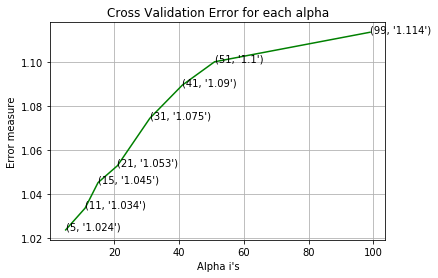

For values of best alpha =  5 The train log loss is: 0.5069677890967376
For values of best alpha =  5 The cross validation log loss is: 1.0236019411611499
For values of best alpha =  5 The test log loss is: 1.0260665393920354


In [70]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.0236019411611499
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


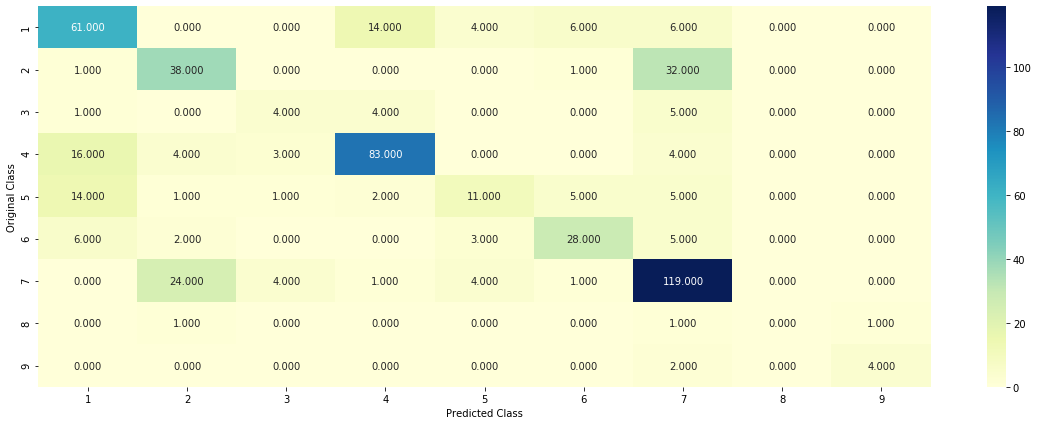

-------------------- Recall matrix (Row sum=1) --------------------


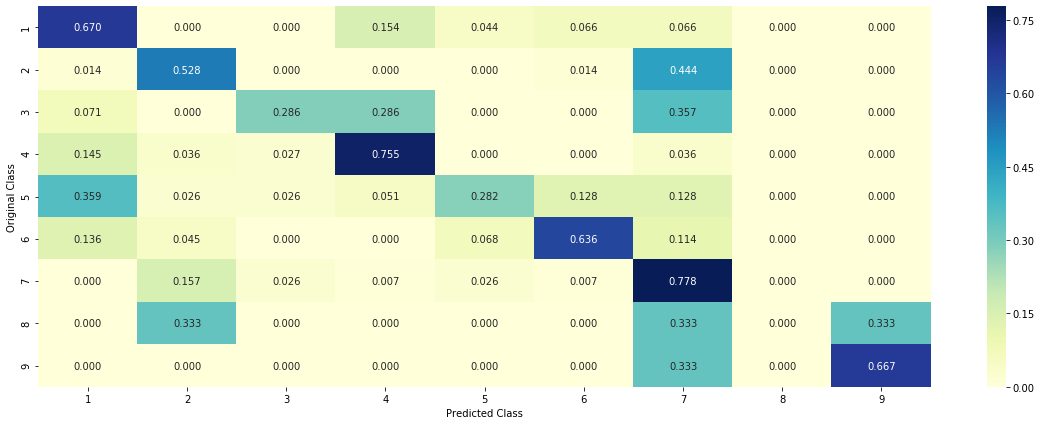

-------------------- Precision matrix (Columm Sum=1) --------------------


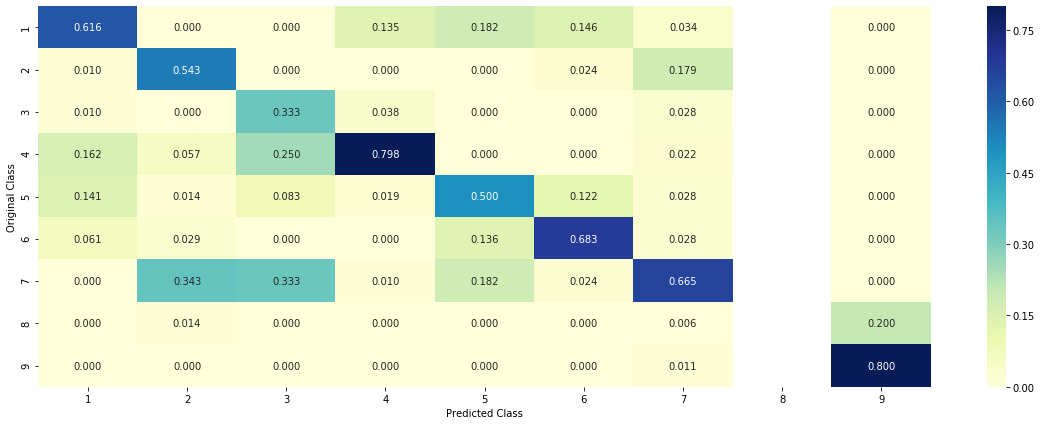

In [71]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [72]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [3 5 4 4 4]
Fequency of nearest points : Counter({4: 3, 3: 1, 5: 1})


<h3>4.2.4. Sample Query Point-2 </h3>

In [73]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [4 4 4 6 4]
Fequency of nearest points : Counter({4: 4, 6: 1})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.3662220689939066
for alpha = 1e-05
Log Loss : 1.361239842074774
for alpha = 0.0001
Log Loss : 1.0971958545067262
for alpha = 0.001
Log Loss : 1.0445201620944153
for alpha = 0.01
Log Loss : 1.1341725257582511
for alpha = 0.1
Log Loss : 1.4221224215171036
for alpha = 1
Log Loss : 1.658554186345001
for alpha = 10
Log Loss : 1.6913328951182707
for alpha = 100
Log Loss : 1.6948899016782875


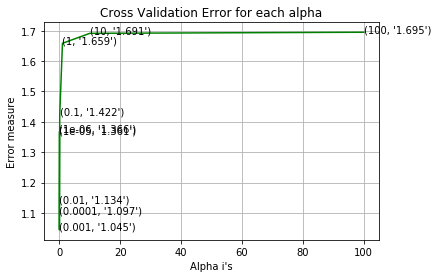

For values of best alpha =  0.001 The train log loss is: 0.5675905652344413
For values of best alpha =  0.001 The cross validation log loss is: 1.0445201620944153
For values of best alpha =  0.001 The test log loss is: 1.0483259151175521


In [74]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.0445201620944153
Number of mis-classified points : 0.3176691729323308
-------------------- Confusion matrix --------------------


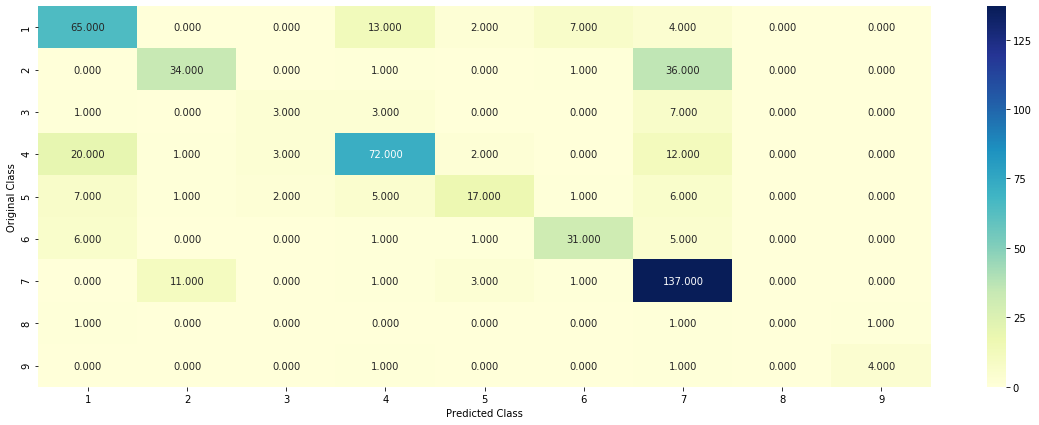

-------------------- Recall matrix (Row sum=1) --------------------


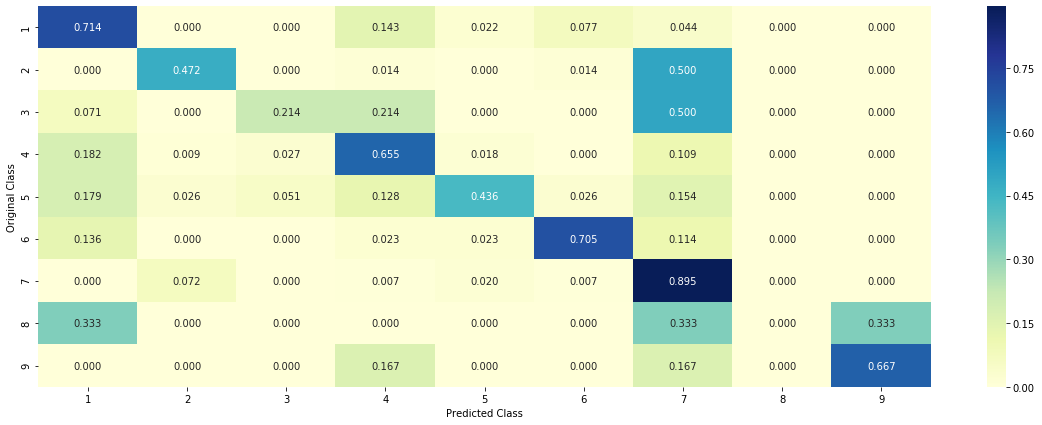

-------------------- Precision matrix (Columm Sum=1) --------------------


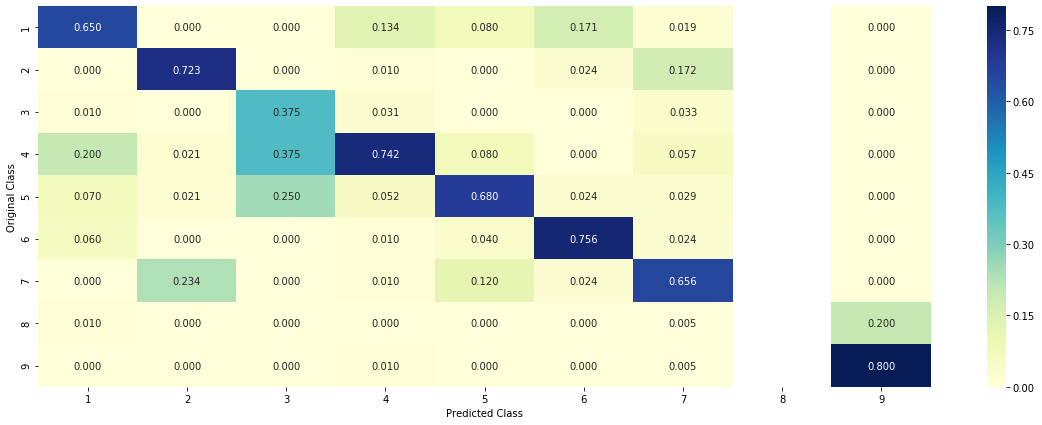

In [75]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [76]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [ ]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h5>4.3.1.3.2. Incorrectly Classified point</h5>

In [78]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[4.27e-02 8.80e-03 1.30e-03 9.03e-01 5.20e-03 2.00e-03 3.28e-02 4.10e-03
  2.00e-04]]
Actual Class : 4
--------------------------------------------------
98 Text feature [nonidet] present in test data point [True]
124 Text feature [suppressor] present in test data point [True]
126 Text feature [activating] present in test data point [True]
203 Text feature [harboring] present in test data point [True]
209 Text feature [a1] present in test data point [True]
218 Text feature [adapted] present in test data point [True]
253 Text feature [novel] present in test data point [True]
262 Text feature [growths] present in test data point [True]
288 Text feature [20k] present in test data point [True]
337 Text feature [sequencing] present in test data point [True]
353 Text feature [r167] present in test data point [True]
354 Text feature [radio] present in test data point [True]
430 Text feature [increasing] present in test data point [True]
431 

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.3365350947392394
for alpha = 1e-05
Log Loss : 1.2857695595114818
for alpha = 0.0001
Log Loss : 1.1140326639424636
for alpha = 0.001
Log Loss : 1.050458056445405
for alpha = 0.01
Log Loss : 1.1617166680164521
for alpha = 0.1
Log Loss : 1.3506001233917795
for alpha = 1
Log Loss : 1.551600309516332


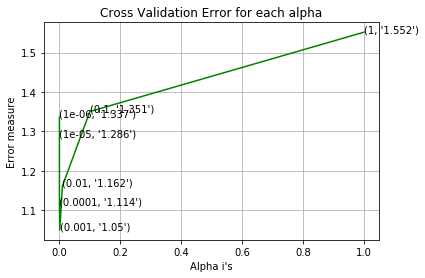

For values of best alpha =  0.001 The train log loss is: 0.5631889775158522
For values of best alpha =  0.001 The cross validation log loss is: 1.050458056445405
For values of best alpha =  0.001 The test log loss is: 1.0627280958883236


In [79]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.050458056445405
Number of mis-classified points : 0.3101503759398496
-------------------- Confusion matrix --------------------


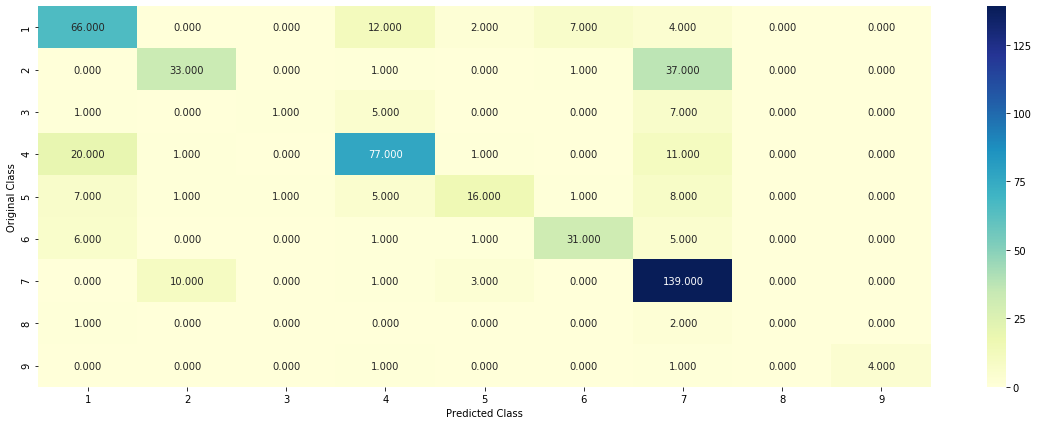

-------------------- Recall matrix (Row sum=1) --------------------


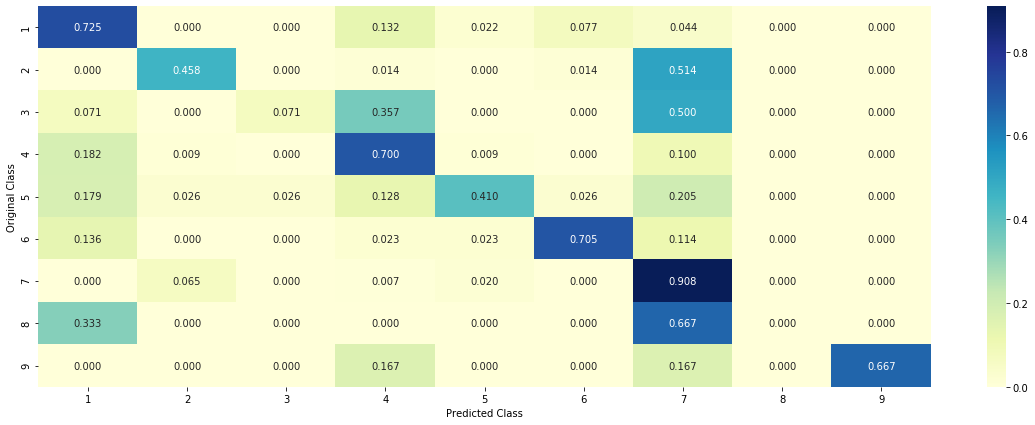

-------------------- Precision matrix (Columm Sum=1) --------------------


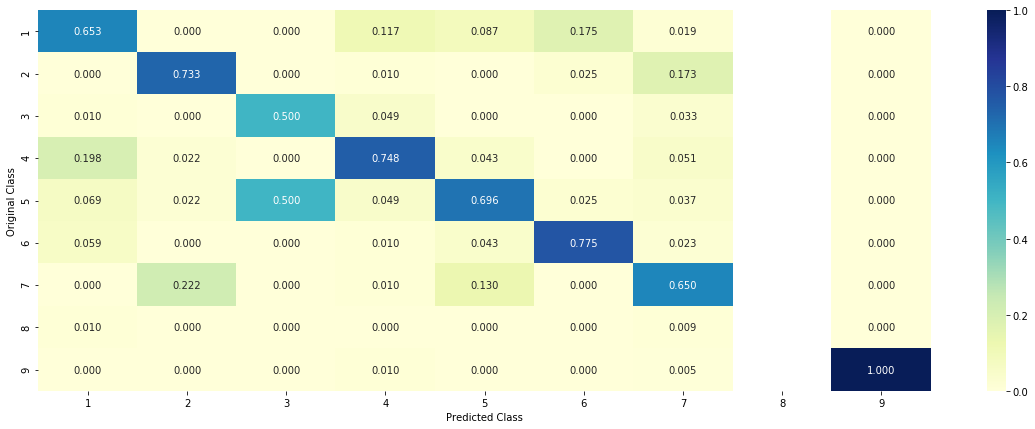

In [80]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [81]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0248 0.0023 0.0315 0.1993 0.7351 0.0051 0.0011 0.0008 0.    ]]
Actual Class : 4
--------------------------------------------------
241 Text feature [v1833m] present in test data point [True]
433 Text feature [encodes] present in test data point [True]
437 Text feature [m1652i] present in test data point [True]
493 Text feature [identified] present in test data point [True]
Out of the top  500  features  4 are present in query point


<h4>4.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [82]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[4.010e-02 8.100e-03 8.000e-04 9.025e-01 3.600e-03 1.700e-03 4.220e-02
  9.000e-04 0.000e+00]]
Actual Class : 4
--------------------------------------------------
147 Text feature [nonidet] present in test data point [True]
192 Text feature [suppressor] present in test data point [True]
224 Text feature [a1] present in test data point [True]
260 Text feature [activating] present in test data point [True]
262 Text feature [adapted] present in test data point [True]
305 Text feature [growths] present in test data point [True]
364 Text feature [harboring] present in test data point [True]
383 Text feature [20k] present in test data point [True]
395 Text feature [radio] present in test data point [True]
430 Text feature [r167] present in test data point [True]
435 Text feature [novel] present in test data point [True]
Out of the top  500  features  11 are present in query point


<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-06
Log Loss : 1.353645005444894
for C = 1e-05
Log Loss : 1.3472715520182739
for C = 0.0001
Log Loss : 1.2737814610461773
for C = 0.001
Log Loss : 1.0961226175861938
for C = 0.01
Log Loss : 1.1014706111550827
for C = 0.1
Log Loss : 1.349850581200082
for C = 1
Log Loss : 1.6795227073334826


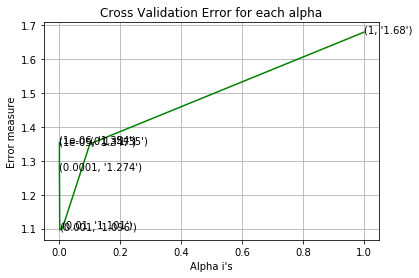

For values of best alpha =  0.001 The train log loss is: 0.5802588502924415
For values of best alpha =  0.001 The cross validation log loss is: 1.0961226175861938
For values of best alpha =  0.001 The test log loss is: 1.1186875882978717


In [87]:
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.0961226175861938
Number of mis-classified points : 0.3157894736842105
-------------------- Confusion matrix --------------------


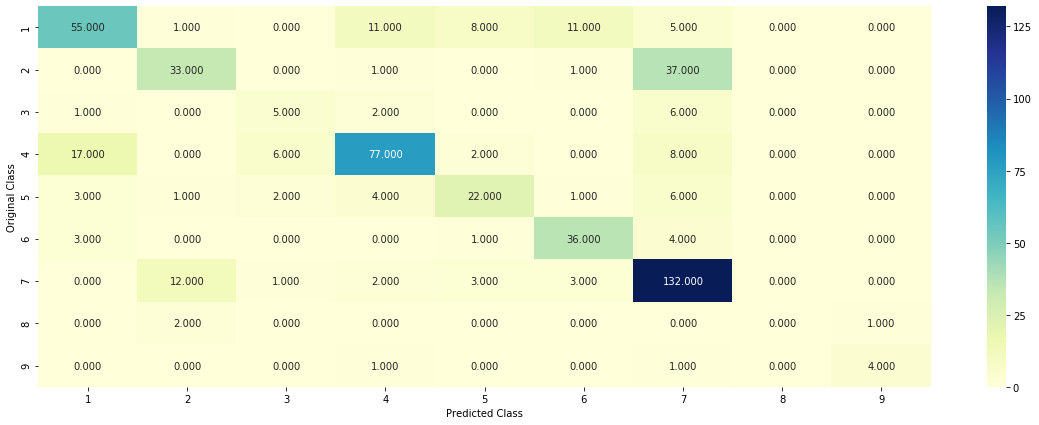

-------------------- Recall matrix (Row sum=1) --------------------


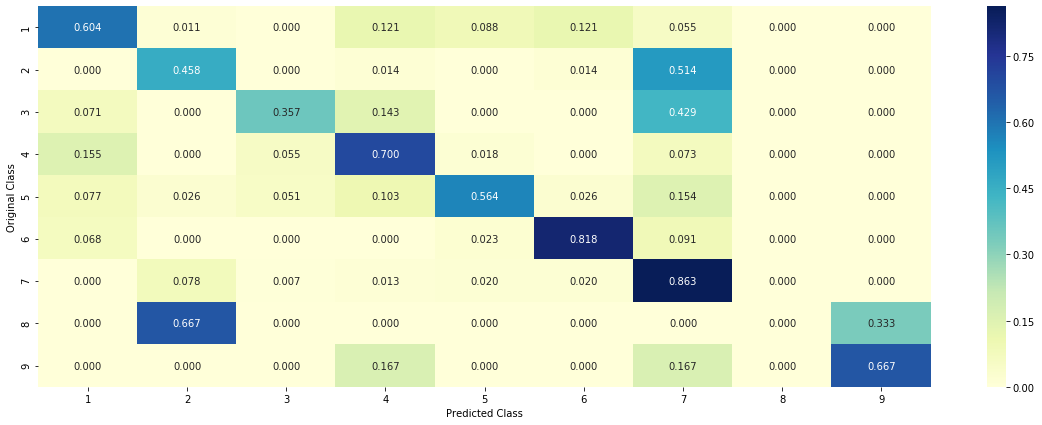

-------------------- Precision matrix (Columm Sum=1) --------------------


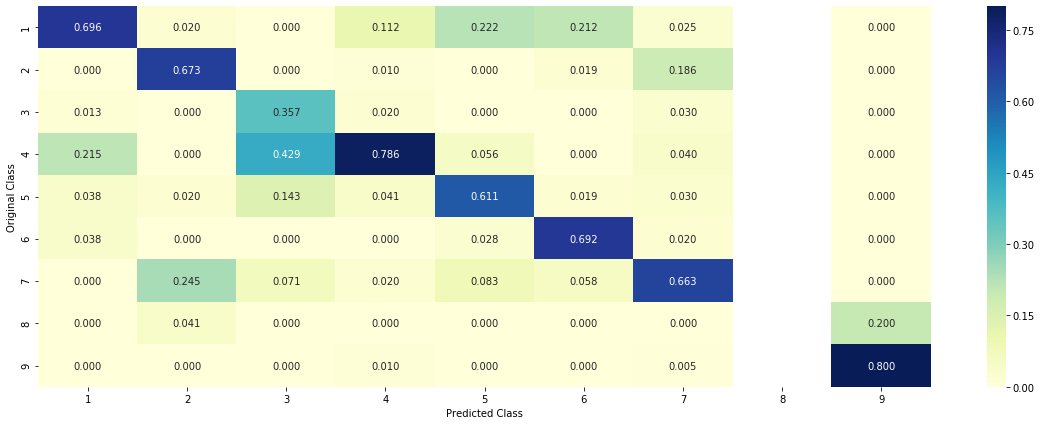

In [88]:
# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For Correctly classified point</h4>

In [93]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100test_point_index
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

SyntaxError: invalid syntax (<ipython-input-93-eccf352553cf>, line 6)

<h4>4.3.3.2. For Incorrectly classified point</h4>

In [91]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0576 0.0297 0.0048 0.745  0.0172 0.006  0.1325 0.003  0.0043]]
Actual Class : 4
--------------------------------------------------
220 Text feature [a1] present in test data point [True]
276 Text feature [nonidet] present in test data point [True]
360 Text feature [20k] present in test data point [True]
390 Text feature [growths] present in test data point [True]
392 Text feature [ccrcc] present in test data point [True]
419 Text feature [suppressor] present in test data point [True]
446 Text feature [degrade] present in test data point [True]
450 Text feature [proxy] present in test data point [True]
457 Text feature [r167] present in test data point [True]
Out of the top  500  features  9 are present in query point


<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [94]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2518684128715463
for n_estimators = 100 and max depth =  10
Log Loss : 1.1601192867701602
for n_estimators = 200 and max depth =  5
Log Loss : 1.2413352736998167
for n_estimators = 200 and max depth =  10
Log Loss : 1.1449507936490484
for n_estimators = 500 and max depth =  5
Log Loss : 1.2353941854752395
for n_estimators = 500 and max depth =  10
Log Loss : 1.142831982924503
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2317481603493992
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1423971356894798
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2314264051635382
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1417995412109225
For values of best estimator =  2000 The train log loss is: 0.7153750068651213
For values of best estimator =  2000 The cross validation log loss is: 1.1417995412109228
For values of best estimator =  2000 The test log loss is: 1.1691326331760539


<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1417995412109225
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


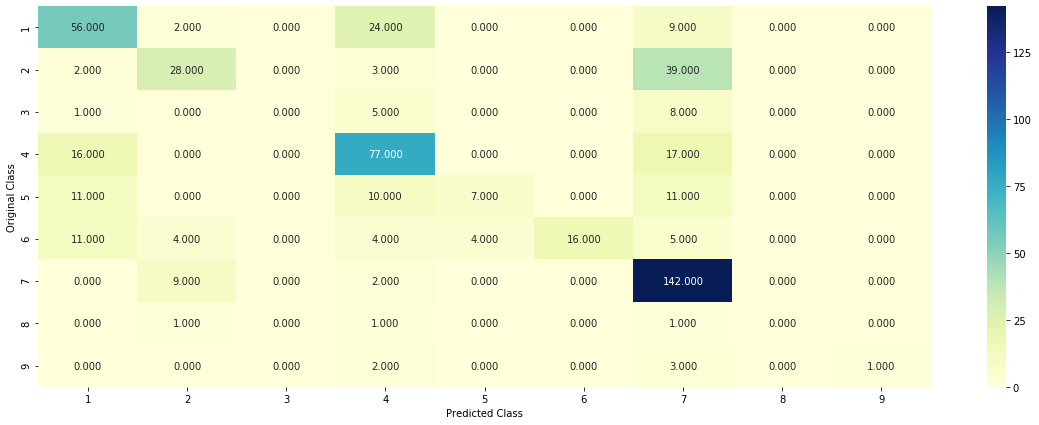

-------------------- Recall matrix (Row sum=1) --------------------


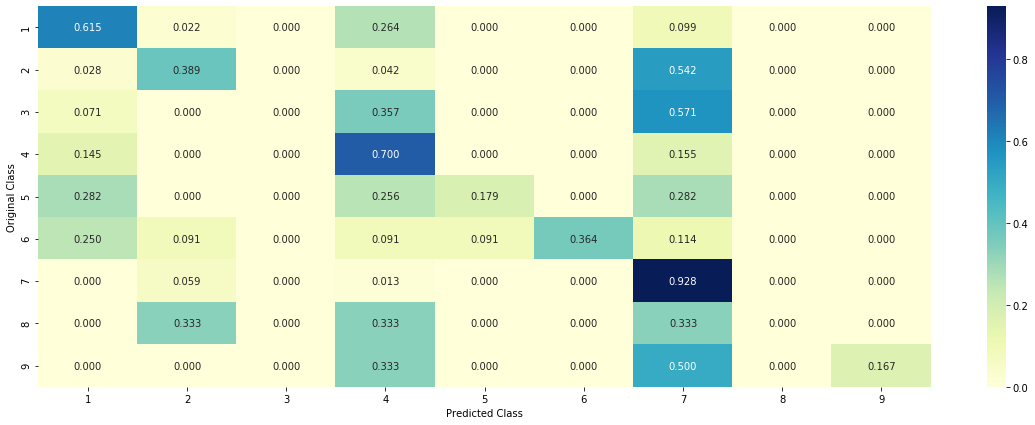

-------------------- Precision matrix (Columm Sum=1) --------------------


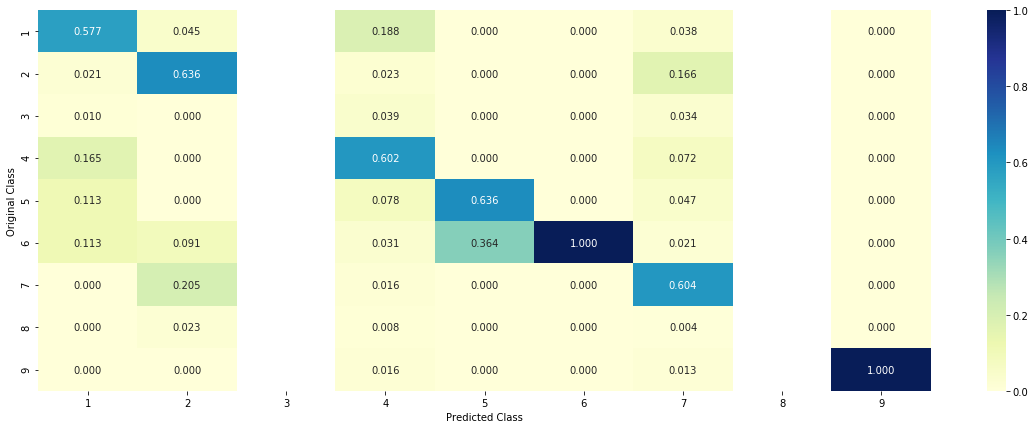

In [96]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly Classified point</h4>

In [97]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0453 0.0134 0.2408 0.4642 0.1557 0.0543 0.018  0.0046 0.0036]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
4 Text feature [activation] present in test data point [True]
5 Text feature [activated] present in test data point [True]
6 Text feature [constitutive] present in test data point [True]
7 Text feature [signaling] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
9 Text feature [phosphorylation] present in test data point [True]
11 Text feature [missense] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [nonsense] present in test data point [True]
18 Text feature [oncogenic] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text fe

<h4>4.5.3.2. Inorrectly Classified point</h4>

In [98]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1944 0.0574 0.0202 0.4843 0.0506 0.0455 0.1344 0.0061 0.0071]]
Actuall Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [activating] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
5 Text feature [activated] present in test data point [True]
7 Text feature [signaling] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
10 Text feature [suppressor] present in test data point [True]
11 Text feature [missense] present in test data point [True]
12 Text feature [treatment] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feature [nonsense] present in test data point [True]
15 Text feature [constitutively] present in test data point [True]
17 Text feature [therapy] present in test data point [True]
18 Text featu

<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [99]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0764632604445126
for n_estimators = 10 and max depth =  3
Log Loss : 1.7660213772123978
for n_estimators = 10 and max depth =  5
Log Loss : 1.7831940720217427
for n_estimators = 10 and max depth =  10
Log Loss : 2.0360402115910237
for n_estimators = 50 and max depth =  2
Log Loss : 1.7502713645676438
for n_estimators = 50 and max depth =  3
Log Loss : 1.5136055041996883
for n_estimators = 50 and max depth =  5
Log Loss : 1.3457201396926388
for n_estimators = 50 and max depth =  10
Log Loss : 1.6805396976669202
for n_estimators = 100 and max depth =  2
Log Loss : 1.6957943756481915
for n_estimators = 100 and max depth =  3
Log Loss : 1.5325421390549292
for n_estimators = 100 and max depth =  5
Log Loss : 1.266142672274994
for n_estimators = 100 and max depth =  10
Log Loss : 1.6682671937961249
for n_estimators = 200 and max depth =  2
Log Loss : 1.721352978403055
for n_estimators = 200 and max depth =  3
Log Loss : 1.5120467150060584

<h3>4.5.4. Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.266142672274994
Number of mis-classified points : 0.44548872180451127
-------------------- Confusion matrix --------------------


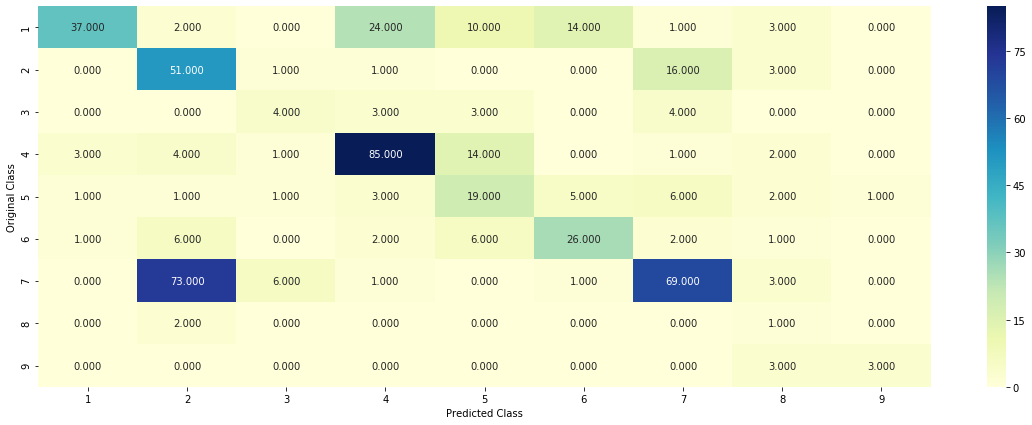

-------------------- Recall matrix (Row sum=1) --------------------


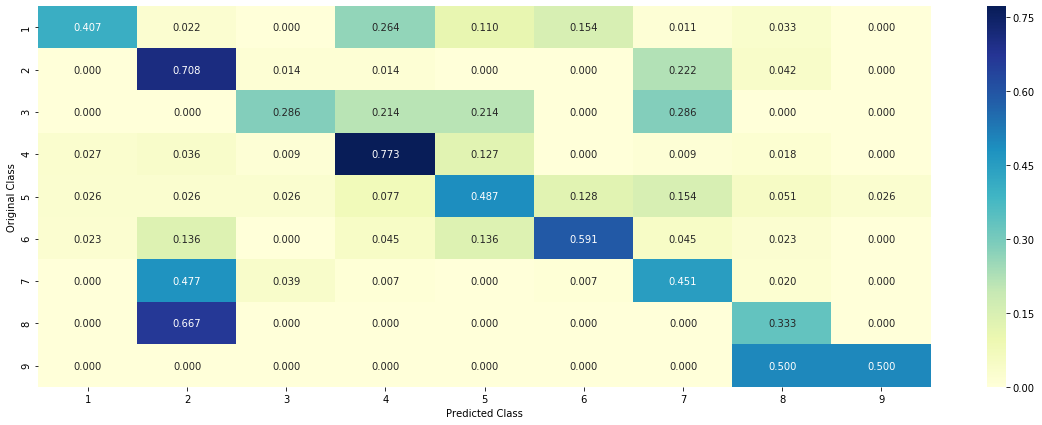

-------------------- Precision matrix (Columm Sum=1) --------------------


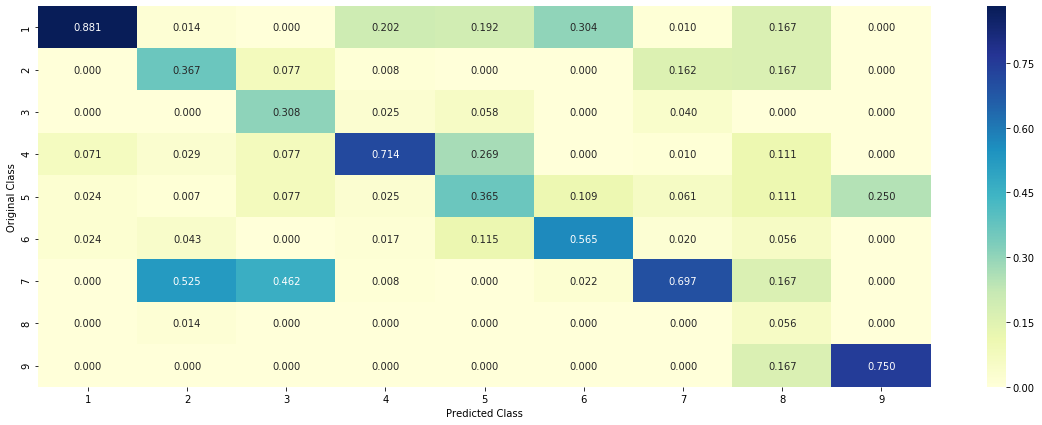

In [100]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

<h3>4.5.5. Feature Importance</h3>

<h4>4.5.5.1. Correctly Classified point</h4>

In [101]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 5
Predicted Class Probabilities: [[0.0149 0.0031 0.2109 0.0261 0.5759 0.1607 0.002  0.0027 0.0037]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h4>4.5.5.2. Incorrectly Classified point</h4>

In [102]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.1599 0.0142 0.1459 0.584  0.0196 0.0388 0.0071 0.0146 0.016 ]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
